# Importing Libraries Needed

In [1]:
! pip install astroNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import utils

from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 5.3 MB/s 
     |████████████████████████████████| 4.5 MB 40.3 MB/s 
     |████████████████████████████████| 832 kB 45.2 MB/s 
     |████████████████████████████████| 48 kB 1.9 MB/s 
     |████████████████████████████████| 4.1 MB 34.9 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284593 sha256=12d4c88b130d2ffdbcb73845097b50133069f7d43c141d00eea729988b326a1b
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astroNN
WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


# The dataset

The galaxy10 dataset is a dataset that contains 21785 69x69 pixels coloured galaxy images with 10 different classes. The images from this dataset come from Sloan Digital Sky Survey and the labels come from Galaxy Zoo Project 2.

In [2]:
images, labels = galaxy10.load_data()

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

features = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round', 'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, Boxy Bulge', 
            'Disk, Edge-on, No Bulge','Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral', 'Disk, Face-on, Loose Spiral']


x_train = x_train / 255.0
x_test = x_test / 255.0


Galaxy10.h5:  98%|█████████▊| 207M/210M [00:03<00:00, 84.1MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:04, 46.5MB/s]                           


# Feature Engineering

In [ ]:
#Isolating the target from the features

X = data.drop(['SPIRAL','ELLIPTICAL','UNCERTAIN'],axis=1).values

Xnew = data.drop(['SPIRAL','ELLIPTICAL','UNCERTAIN'],axis=1)

y = data[['SPIRAL','ELLIPTICAL','UNCERTAIN']].values

ynew = data[['SPIRAL','ELLIPTICAL','UNCERTAIN']]

discrete_features = X.dtype == 'float64'

#y= y.reshape(667944)
from sklearn.feature_selection import mutual_info_regression

def make_mi_score( X, y, discrete_features):
  mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index= Xnew.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

mi_scores = make_mi_score(X, y, discrete_features)
print(mi_scores[::3])



# Understanding the dataset

In [3]:
train_shape = x_train.shape
test_shape = x_test.shape

print(train_shape, test_shape)

(17428, 69, 69, 3) (4357, 69, 69, 3)


In [5]:
x_train

array([[[[0.00784314, 0.00392157, 0.        ],
         [0.01568627, 0.01176471, 0.00784314],
         [0.03921569, 0.03529412, 0.02745098],
         ...,
         [0.03921569, 0.03137255, 0.01568627],
         [0.05882353, 0.05098039, 0.03529412],
         [0.04705882, 0.03921569, 0.02352941]],

        [[0.01176471, 0.00784314, 0.        ],
         [0.01960784, 0.01568627, 0.00784314],
         [0.01960784, 0.01568627, 0.00784314],
         ...,
         [0.04705882, 0.03921569, 0.01960784],
         [0.05882353, 0.05098039, 0.03529412],
         [0.04705882, 0.03921569, 0.02352941]],

        [[0.01960784, 0.01568627, 0.00784314],
         [0.01960784, 0.01568627, 0.00784314],
         [0.01568627, 0.01176471, 0.00392157],
         ...,
         [0.02352941, 0.01960784, 0.00392157],
         [0.02745098, 0.02352941, 0.00392157],
         [0.02352941, 0.01960784, 0.00392157]],

        ...,

        [[0.08627451, 0.07058824, 0.03137255],
         [0.07058824, 0.05098039, 0.02745098]

17248 training pictures with 69x69 dimensions and 
4357 testing pictures with 69x69 dimensions

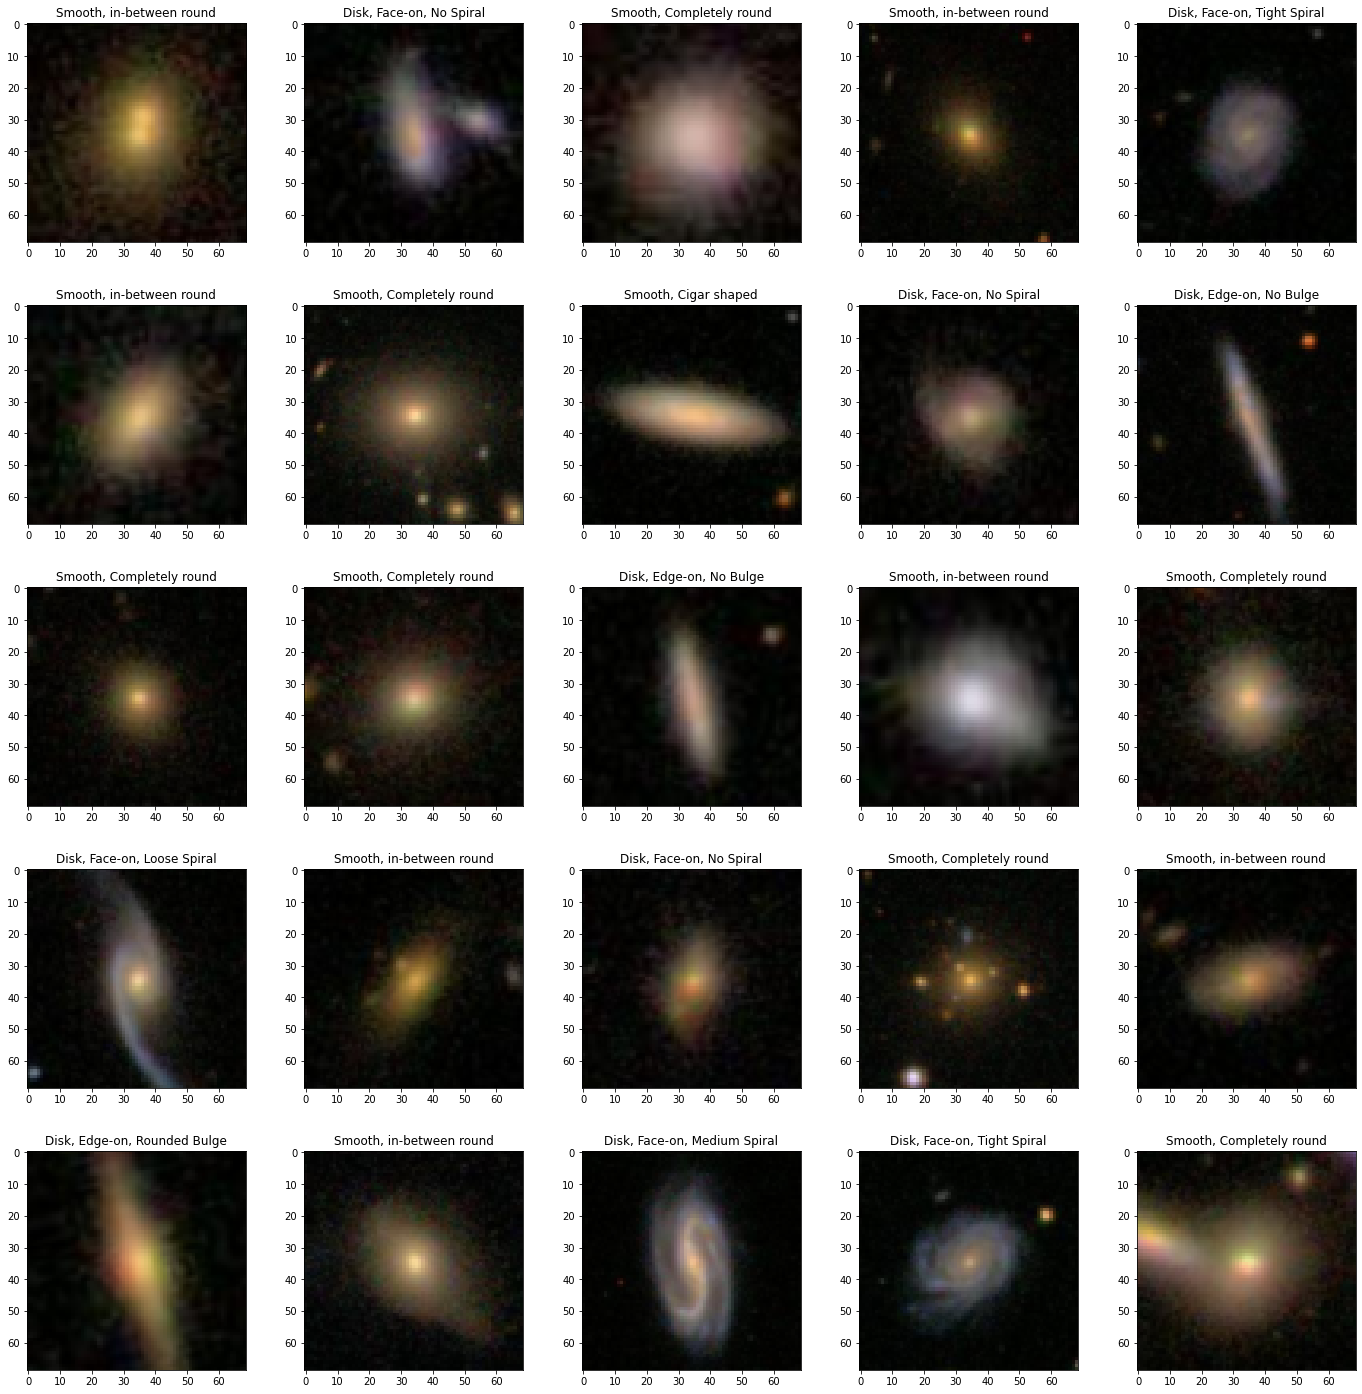

In [6]:
#Visualizing the dataset

fig = plt.figure(figsize=(20,20)) 

for i in range(25):
    plt.subplot(5,5,i+1)    
    plt.imshow(x_train[i])
    plt.title(features[y_train[i]])
    fig.tight_layout(pad=3.0)
    
plt.show()

0    3461
1    6997
2    6292
3     349
4    1534
5      17
6     589
7    1121
8     906
9     519
dtype: int64


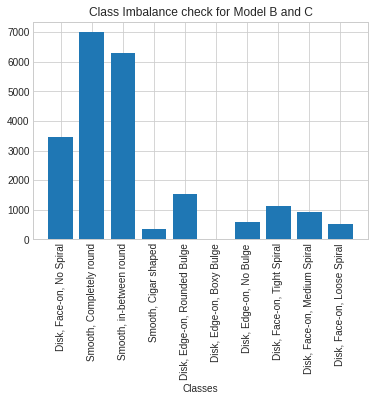

In [41]:
#Check for class imbalance

df = pd.DataFrame(data=labels)

counts = df.value_counts().sort_index()
print(counts)

def class_distribution(x, y, labels):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_xticklabels(labels, rotation=90)
    plt.title('Class Imbalance check for Model B and C')
    plt.xlabel('Classes')
    plt.show()
    
class_distribution(features, counts, features)


**Imbalanced Data: The Accuracy Paradox**

Here, we have quite an unbalanced dataset. The number of images in each class range from 17 (min) in class 5 and 6997 (max) in class 1. The issue with data that has skewed class distributions is that accuracy is no longer an evaluation metric that correctly reflects the machine learning model’s ability to classify the images. This is also known as the accuracy paradox which states that a model with a higher accuracy might have less predictive power than a model with lower accuracy.

# The model : building and training

In [8]:
model = Sequential()

# Baseline model to compare to LeNet-5
model.add(Flatten(input_shape=(69, 69, 3)))
model.add(Dense(128, activation='relu'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(10, activation='softmax'))

model_optimizer = Adam(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14283)             0         
                                                                 
 dense (Dense)               (None, 128)               1828352   
                                                                 
 dense_1 (Dense)             (None, 84)                10836     
                                                                 
 dense_2 (Dense)             (None, 10)                850       
                                                                 
Total params: 1,840,038
Trainable params: 1,840,038
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer=model_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
reduceLR = ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=1, min_delta=0.01, mode="auto")

fitting = model.fit(x_train, y_train, epochs=20, callbacks=[reduceLR])


Epoch 1/20
545/545 [==============================] - 10s 18ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 1.0005e-42
Epoch 2/20
545/545 [==============================] - 10s 17ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 1.0005e-42
Epoch 3/20
545/545 [==============================] - 10s 17ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 1.4013e-45
Epoch 4/20
545/545 [==============================] - 11s 21ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 0.0000e+00
Epoch 5/20
545/545 [==============================] - 10s 17ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 0.0000e+00
Epoch 6/20
545/545 [==============================] - 10s 18ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 0.0000e+00
Epoch 7/20
545/545 [==============================] - 10s 19ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 0.0000e+00
Epoch 8/20
545/545 [==============================] - 13s 23ms/step - loss: 0.6596 - accuracy: 0.7591 - lr: 0.0000e+00
Epoch 9/20
545/545 [============================

In [26]:
predict = model.predict(x_test).argmax(axis=1)

for i in range(10):
    print("Actual:", features[y_test[i]])
    print("Prediction:", features[np.argmax(predict[i])])
    print("-----")
    print()

137/137 [==============================] - 1s 6ms/step
Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Edge-on, Rounded Bulge
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Edge-on, Rounded Bulge
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, No Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, Completely round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, No Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, Completely round
Prediction: Disk, Face-on, No Spiral
-----



Model evaluation

In [16]:
report1 = classification_report(y_test, predict)

print(report1)

              precision    recall  f1-score   support

           0       0.43      0.47      0.45       696
           1       0.82      0.89      0.85      1414
           2       0.75      0.83      0.79      1267
           3       0.45      0.13      0.21        67
           4       0.68      0.86      0.76       292
           5       0.00      0.00      0.00         5
           6       0.73      0.70      0.71       122
           7       0.41      0.22      0.28       225
           8       0.13      0.01      0.02       165
           9       0.20      0.06      0.09       104

    accuracy                           0.70      4357
   macro avg       0.46      0.42      0.42      4357
weighted avg       0.66      0.70      0.67      4357



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(36.5, 0.5, 'True class')

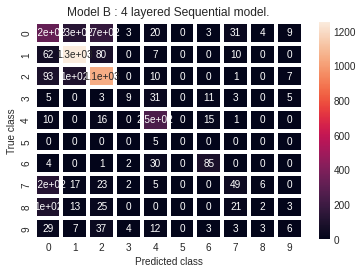

In [39]:
#A confussion matrix

matrix = confusion_matrix(y_test, predict)
sns.heatmap(matrix, annot=True, linewidths=3)
plt.title('Model B : 4 layered Sequential model.')
plt.xlabel('Predicted class')
plt.ylabel('True class')

In [32]:
results = model.evaluate(x_test, y_test, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.84525
Test Accuracy: 69.64%


Model 2: Pretrained model

In [28]:
model2 = Sequential()

# LeNet-5 convolutional-neural network 
model2.add(Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation='tanh', input_shape=(69,69,3)))
model2.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model2.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='tanh'))
model2.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=120, activation='tanh'))
model2.add(Dense(units=84, activation='tanh'))
model2.add(Dense(units=10, activation='softmax'))

model_optimizer = Adam(lr=0.001)

reduceLR = ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=1, min_delta=0.01, mode="auto")

model2.compile(optimizer=model_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model2.fit(x_train, y_train, epochs=10, callbacks=[reduceLR])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
545/545 [==============================] - 92s 166ms/step - loss: 1.2893 - accuracy: 0.5028 - lr: 0.0010
Epoch 2/10
545/545 [==============================] - 82s 150ms/step - loss: 0.8582 - accuracy: 0.6874 - lr: 0.0010
Epoch 3/10
545/545 [==============================] - 82s 150ms/step - loss: 0.7291 - accuracy: 0.7301 - lr: 0.0010
Epoch 4/10
545/545 [==============================] - 80s 146ms/step - loss: 0.6421 - accuracy: 0.7655 - lr: 0.0010
Epoch 5/10
545/545 [==============================] - 79s 146ms/step - loss: 0.5678 - accuracy: 0.7930 - lr: 0.0010
Epoch 6/10
545/545 [==============================] - 91s 166ms/step - loss: 0.4970 - accuracy: 0.8226 - lr: 0.0010
Epoch 7/10
545/545 [==============================] - 93s 170ms/step - loss: 0.4388 - accuracy: 0.8391 - lr: 0.0010
Epoch 8/10
545/545 [==============================] - 80s 147ms/step - loss: 0.3678 - accuracy: 0.8701 - lr: 0.0010
Epoch 9/10
545/545 [==============================] - 82s 150ms/step - l

In [33]:
predict2 = model2.predict(x_test).argmax(axis=1)

for i in range(10):
    print("Actual:", features[y_test[i]])
    print("Prediction:", features[np.argmax(predict[i])])
    print("-----")
    print()

137/137 [==============================] - 7s 54ms/step
Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Edge-on, Rounded Bulge
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Edge-on, Rounded Bulge
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, No Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, Completely round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, No Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, Completely round
Prediction: Disk, Face-on, No Spiral
-----



In [34]:
report2 = classification_report(y_test, predict2)

print(report2)

              precision    recall  f1-score   support

           0       0.46      0.58      0.51       696
           1       0.90      0.85      0.87      1414
           2       0.83      0.84      0.83      1267
           3       0.61      0.45      0.52        67
           4       0.78      0.83      0.80       292
           5       0.00      0.00      0.00         5
           6       0.74      0.70      0.72       122
           7       0.45      0.49      0.47       225
           8       0.49      0.21      0.29       165
           9       0.42      0.27      0.33       104

    accuracy                           0.73      4357
   macro avg       0.57      0.52      0.54      4357
weighted avg       0.74      0.73      0.73      4357



Text(36.5, 0.5, 'True class')

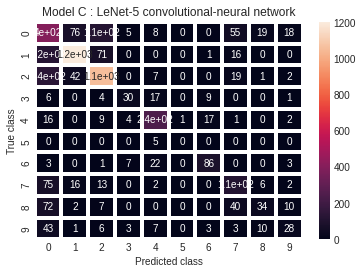

In [38]:
matrix = confusion_matrix(y_test, predict2)
sns.heatmap(matrix, annot=True, linewidths=3)
plt.title('Model C : LeNet-5 convolutional-neural network')
plt.xlabel('Predicted class')
plt.ylabel('True class')

In [36]:
results = model2.evaluate(x_test, y_test, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.84935
Test Accuracy: 73.38%
